In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error, make_scorer, median_absolute_error, roc_curve, roc_auc_score, auc, classification_report

In [2]:
data_type = 'chr_'
data = pd.read_csv('Data/ChrFeatures.csv')
labels = pd.read_csv('Data/20190815_WPS_NORM.hackathon_sample_info.csv')

In [3]:
data.shape

(314, 310)

In [4]:
u = list(labels['library'])
data = data[data['0'].isin(u)]
data = data.reset_index()
del data['index']
labels.rename(columns={'library':'PatientId'}, inplace=True)
data.rename(columns={'0':'PatientId'}, inplace=True)

In [5]:
data.shape

(314, 310)

In [6]:
labels = labels.sort_values(by=['PatientId'])
data = data.sort_values(by=['PatientId'])

In [7]:
names = data.columns
samples_id = list(data['PatientId'])
del data['PatientId']

In [8]:
X = data.values
Y = labels['estimated.purity'].values

In [9]:
# Remove row(s) with nan values
ell = np.argwhere(np.isnan(X).any(axis=1))
X = np.delete(X,ell,0)
Y = np.delete(Y,ell,0)

In [10]:
indices = [i for i in range(len(X))]

In [11]:
X_train, X_test, Y_train, Y_test, indices_train, indices_test = train_test_split(X, Y, indices, test_size = 0.2) 

In [12]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(250, 309) (250,)
(63, 309) (63,)


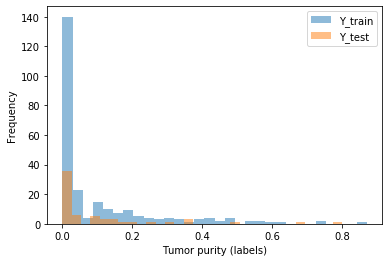

In [13]:
l1 = plt.hist(Y_train,bins=30, alpha=0.5, label='Y_train')
l2 = plt.hist(Y_test,bins=30, alpha=0.5, label='Y_test')
plt.legend
plt.xlabel('Tumor purity (labels)')
plt.ylabel('Frequency')
plt.legend(loc="upper right")
plt.show()

In [14]:
##########################################
############ Data Rescaling ##############
##########################################

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
dict_regressions = {
    "Gradient Boosting Regression": GradientBoostingRegressor(), #Gradient Boosting for regression.
    #GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of 
    #arbitrary differentiable loss functions. In each stage a regression tree is fit on the negative 
    #gradient of the given loss function.
    "Random Forest": RandomForestRegressor(), #A random forest regressor.
    #A random forest is a meta estimator that fits a number of classifying decision trees on various 
    #sub-samples of the dataset and uses averaging to improve the predictive accuracy and control 
    #over-fitting. 
    "Epsilon-Support Vector Regression": SVR(gamma='scale', C=1.0, epsilon=0.2, kernel='linear'),
    "AdaBoost": AdaBoostRegressor() # An AdaBoost regressor.
    #An AdaBoost regressor is a meta-estimator that begins by fitting a regressor on the original 
    #dataset and then fits additional copies of the regressor on the same dataset but where the weights
    #of instances are adjusted according to the error of the current prediction. As such, subsequent regressors 
    #focus more on difficult cases.
}

In [17]:
rms_models = {}
kf = KFold(n_splits=10)

In [18]:
for reg_name, clf in list(dict_regressions.items()):
    print(reg_name)
    rms_scorer_train = []
    rms_scorer_test = []

    count_set = 0
    for train_index,_ in kf.split(X_train):
        print('cross- validation set %s' % count_set)
        count_set += 1
        clf.fit(X_train[train_index], Y_train[train_index])
        
        ## TRAINING set ##
        Y_fitted = clf.predict(X_train[train_index])
        rms_scorer_train.append(mean_squared_error(Y_train[train_index], Y_fitted))

        ## TESTING set ##
        Y_predicted = clf.predict(X_test)
        rms_scorer_test.append(mean_squared_error(Y_test, Y_predicted))

    rms_models[reg_name] = {'Model': clf, 'Score_training': rms_scorer_train,'Score_testing': rms_scorer_test}

Gradient Boosting Regression
cross- validation set 0
cross- validation set 1
cross- validation set 2
cross- validation set 3
cross- validation set 4
cross- validation set 5
cross- validation set 6
cross- validation set 7
cross- validation set 8
cross- validation set 9
Random Forest
cross- validation set 0
cross- validation set 1
cross- validation set 2
cross- validation set 3
cross- validation set 4
cross- validation set 5
cross- validation set 6
cross- validation set 7
cross- validation set 8
cross- validation set 9
Epsilon-Support Vector Regression
cross- validation set 0
cross- validation set 1
cross- validation set 2
cross- validation set 3
cross- validation set 4
cross- validation set 5
cross- validation set 6
cross- validation set 7
cross- validation set 8
cross- validation set 9
AdaBoost
cross- validation set 0
cross- validation set 1
cross- validation set 2
cross- validation set 3
cross- validation set 4
cross- validation set 5
cross- validation set 6
cross- validation set 7
cr

In [19]:
##############################################################
###################  Performance Metrics #####################
##############################################################

In [19]:
for reg_name, scores in list(rms_models.items()):
    n, min_max, mean, var, skew, kurt = stats.describe(scores['Score_training'])
    std = np.sqrt(var)
    Conf_Interval = stats.norm.interval(0.05,loc=mean,scale=std)
    
    n2, min_max2, mean2, var2, skew2, kurt2 = stats.describe(scores['Score_testing'])
    std2 = np.sqrt(var2)
    Conf_Interval2 = stats.norm.interval(0.05,loc=mean2,scale=std2)
    print("***********************************************")
    print("Models:",reg_name)
    print("Training     Mean: ",mean,"        C.I: ",Conf_Interval)
    print("Testing      Mean: ",mean2,"       C.I: ",Conf_Interval2)

***********************************************
Models: Gradient Boosting Regression
Training     Mean:  8.230345379032571e-05         C.I:  (8.147885722950165e-05, 8.312805035114977e-05)
Testing      Mean:  0.008406536822635393        C.I:  (0.008375203428227292, 0.008437870217043494)
***********************************************
Models: Random Forest
Training     Mean:  0.0013763416324158839         C.I:  (0.0013687578810587446, 0.0013839253837730232)
Testing      Mean:  0.00798167946599889        C.I:  (0.007950728624088427, 0.008012630307909354)
***********************************************
Models: Epsilon-Support Vector Regression
Training     Mean:  0.011757884878421132         C.I:  (0.011686242063899198, 0.011829527692943067)
Testing      Mean:  0.013649604688753092        C.I:  (0.013551270514124913, 0.01374793886338127)
***********************************************
Models: AdaBoost
Training     Mean:  0.003080889675039814         C.I:  (0.0030651152922748395, 0.00309666

In [20]:
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

***********************************************
Model:  Gradient Boosting Regression


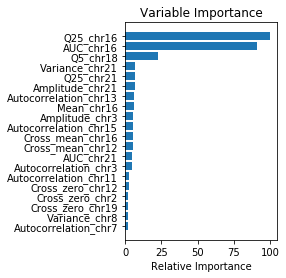

Model: Gradient Boosting Regression performance Measures: on TESTING set


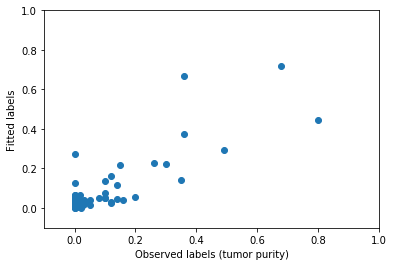

Mean Squared Error : 0.008128509442623822


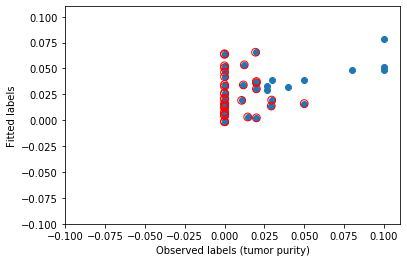

              
Evaluation of low tumor purity (i.e. less than or equal 10%)
Mean Squared Error : 0.002745008674684088
              
 Classification 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.60      1.00      0.75        38

    accuracy                           0.60        63
   macro avg       0.30      0.50      0.38        63
weighted avg       0.36      0.60      0.45        63



/Users/anamaria1/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


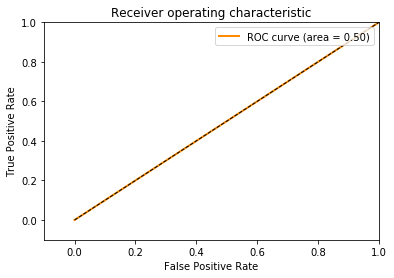

Writing to file...
***********************************************
Model:  Random Forest


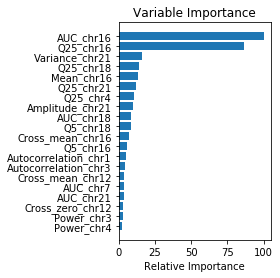

Model: Random Forest performance Measures: on TESTING set


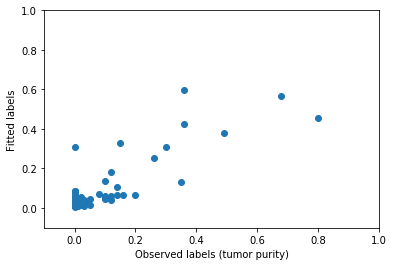

Mean Squared Error : 0.007803874508205323


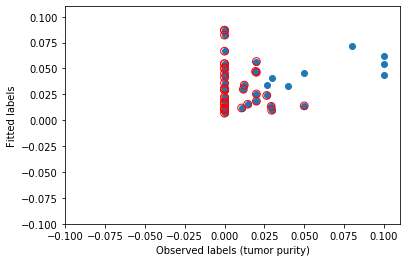

              
Evaluation of low tumor purity (i.e. less than or equal 10%)
Mean Squared Error : 0.0033568947220631138
              
 Classification 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.60      1.00      0.75        38

    accuracy                           0.60        63
   macro avg       0.30      0.50      0.38        63
weighted avg       0.36      0.60      0.45        63



/Users/anamaria1/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


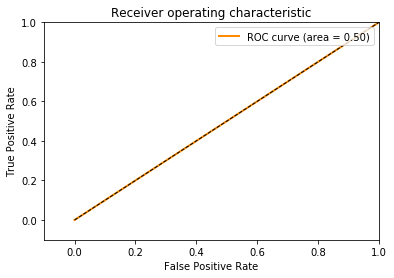

Writing to file...
***********************************************
Model:  Epsilon-Support Vector Regression


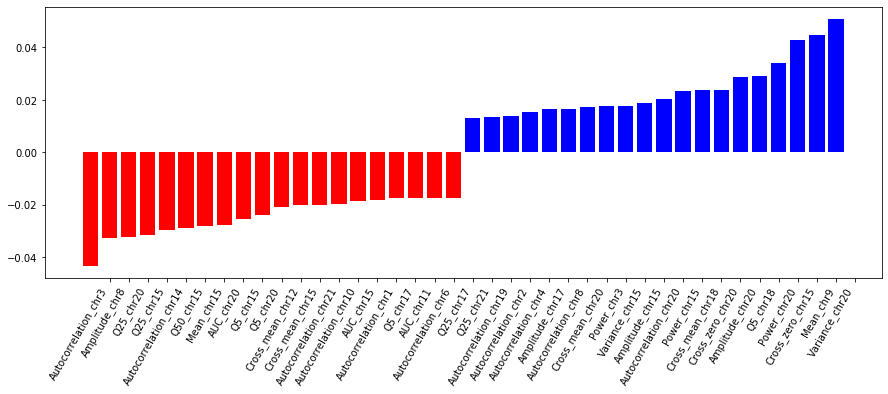

Model: Epsilon-Support Vector Regression performance Measures: on TESTING set


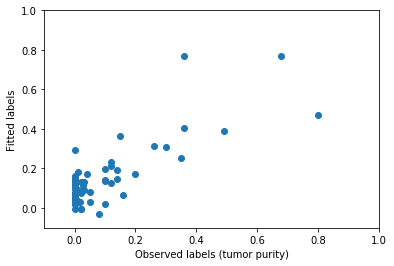

Mean Squared Error : 0.013218083669835394


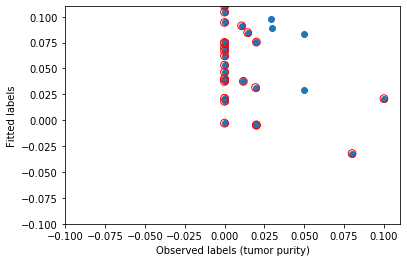

              
Evaluation of low tumor purity (i.e. less than or equal 10%)
Mean Squared Error : 0.009453565612025289
              
 Classification 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.60      1.00      0.75        38

    accuracy                           0.60        63
   macro avg       0.30      0.50      0.38        63
weighted avg       0.36      0.60      0.45        63



/Users/anamaria1/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


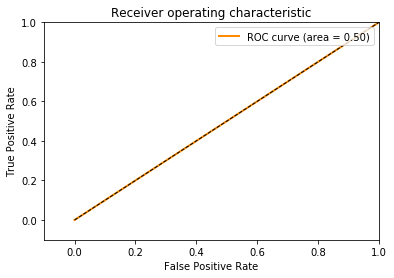

Writing to file...
***********************************************
Model:  AdaBoost


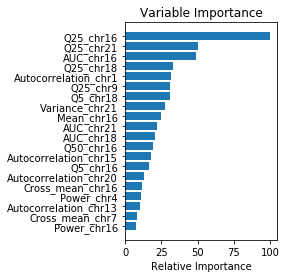

Model: AdaBoost performance Measures: on TESTING set


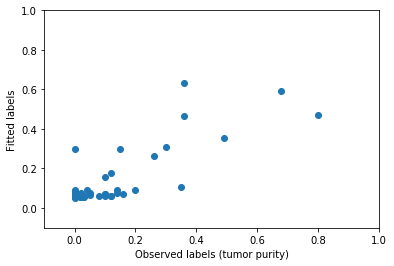

Mean Squared Error : 0.008884594536751464


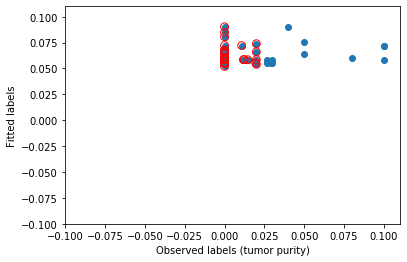

              
Evaluation of low tumor purity (i.e. less than or equal 10%)
Mean Squared Error : 0.004722625096989811
              
 Classification 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.60      1.00      0.75        38

    accuracy                           0.60        63
   macro avg       0.30      0.50      0.38        63
weighted avg       0.36      0.60      0.45        63



/Users/anamaria1/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


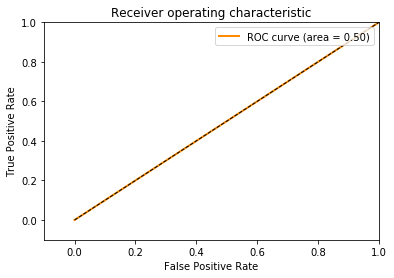

Writing to file...


In [29]:
for reg_name, clf in list(dict_regressions.items()):
    if reg_name not in ['Epsilon-Support Vector Regression']:
        print('***********************************************')
        print('Model: ',reg_name)
        
        clf.fit(X_train, Y_train)
        feature_importance = clf.feature_importances_
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        plt.subplot(1, 2, 2)
        num_features = 20
        plt.barh(pos[-num_features:], feature_importance[sorted_idx][-num_features:], align='center')
        plt.yticks(pos[-num_features:], data.columns[sorted_idx][-num_features:])
        plt.xlabel('Relative Importance')
        plt.title('Variable Importance')
        plt.show()
    else:
        print('***********************************************')
        print('Model: ',reg_name)
        
        clf.fit(X_train, Y_train)
        plot_coefficients(clf,names)
     
    print('Model: %s performance Measures: on TESTING set' % reg_name)
             
    Y_fitted = clf.predict(X_test)
        
    plt.scatter(Y_test, Y_fitted)
    plt.xlabel('Observed labels (tumor purity)')
    plt.ylabel('Fitted labels')
    plt.xlim([-0.1,1])
    plt.ylim([-0.1,1])
    plt.show()
    #print('Median Absolute Error :', median_absolute_error(Y_test, Y_fitted))
    print('Mean Squared Error :', mean_squared_error(Y_test, Y_fitted))
        
    pred_fit = pd.DataFrame()
    pred_fit['Y_fitted'] = Y_fitted
    pred_fit['Y_test'] = Y_test
    pred_fit = pred_fit[pred_fit['Y_test']<=0.1]
    disc_ind = (pred_fit['Y_test']<0.025) | (pred_fit['Y_fitted']<0.025)
    plt.scatter(list(pred_fit['Y_test']),list(pred_fit['Y_fitted']))
    plt.scatter(pred_fit['Y_test'][disc_ind],pred_fit['Y_fitted'][disc_ind],s=60,marker='o',color='r',facecolors='none')
    plt.xlabel('Observed labels (tumor purity)')
    plt.ylabel('Fitted labels')
    plt.xlim([-0.1,0.11])
    plt.ylim([-0.1,0.11])
    plt.show()
    print('              ')
    print('Evaluation of low tumor purity (i.e. less than or equal 10%)')
    #print('Median Absolute Error :', median_absolute_error(list(pred_fit['Y_test']), list(pred_fit['Y_fitted'])))
    print('Mean Squared Error :', mean_squared_error(list(pred_fit['Y_test']), list(pred_fit['Y_fitted'])))
        
        
    ############################################
    print("              ")
    print(" Classification ")
    threshold = 0.00
    pred_fit = pd.DataFrame()
    pred_fit['Y_fitted']= Y_fitted
    pred_fit['Y_test'] = Y_test
    pred_fit['Y_fitted'] = np.where(pred_fit['Y_fitted'] == threshold, 0, 1)
    pred_fit['Y_test'] = np.where(pred_fit['Y_test'] == threshold, 0, 1)
        
    print(classification_report(pred_fit['Y_test'], pred_fit['Y_fitted']))
        
    fpr, tpr, thresholds = roc_curve(pred_fit['Y_test'], pred_fit['Y_fitted'])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0,1], [0,1], color='k', lw=1, linestyle='--')
    plt.xlim([-0.1,1])
    plt.ylim([-0.1,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="upper right")
    plt.show()
        
    #############################################
    print('Writing to file...')
    Y_fitted_test = clf.predict(X_test)
    Y_fitted_train = clf.predict(X_train)
    pred_fit_train = pd.DataFrame()
    pred_fit_test = pd.DataFrame()

    pred_fit_train['Y_fitted'] = Y_fitted_train
    pred_fit_train['Y_orig'] = Y_train
    pred_fit_train['id'] = indices_train

    pred_fit_test['Y_fitted'] = Y_fitted_test
    pred_fit_test['Y_orig'] = Y_test
    pred_fit_test['id'] = indices_test
        
    pred_fit_train['PatientId'] = pred_fit_train['id'].apply(lambda x: samples_id[x])
    pred_fit_test['PatientId'] = pred_fit_test['id'].apply(lambda x: samples_id[x])
        
    pred_fit_train.to_csv(''.join([data_type,reg_name,'Training_fitted_values.csv']))
    pred_fit_test.to_csv(''.join([data_type,reg_name,'Testing_fitted_values.csv']))

In [30]:
user_point = 'LIB-ZNNIZZ'

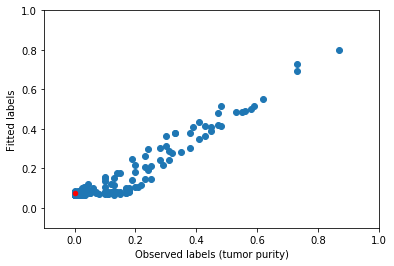

In [23]:
plt.scatter(list(pred_fit_train['Y_orig']), list(pred_fit_train['Y_fitted']))
plt.scatter(list(pred_fit_train[pred_fit_train['PatientId']==user_point]['Y_orig']), list(pred_fit_train[pred_fit_train['PatientId']==user_point]['Y_fitted']), s=20, c ='r')
plt.xlabel('Observed labels (tumor purity)')
plt.ylabel('Fitted labels')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1]);